<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_04_03_survival_analysis_frailty_models_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 4.3 Frailty Models


Frailty models are extensions of standard survival analysis techniques, such as the Cox proportional hazards (PH) model, designed to handle unobserved heterogeneity or clustering in time-to-event data. In survival analysis, we often study the time until an event occurs (e.g., death, failure, or recurrence), but not all factors influencing the risk (hazard) may be observed or measurable. Frailty models introduce a random effect, called "frailty," to account for this unobserved variation.


### Key Concepts


- **Basic Idea**: In a standard Cox PH model, the hazard rate for an individual is $h(t | X) = h_0(t) \exp(\beta^T X)$, where $h_0(t)$ is the baseline hazard, $X$ are covariates, and $\beta$ are coefficients. Frailty models modify this to $h(t | X, u) = u \cdot h_0(t) \exp(\beta^T X)$, where $u$ is the frailty term—a non-negative random variable with mean 1 (for identifiability) and variance $\theta$ (which measures the degree of heterogeneity). Higher frailty ($u > 1$) means higher risk, and vice versa.

- **Unobserved Heterogeneity**: If important covariates are omitted, the population appears more homogeneous over time because "frailer" individuals experience the event earlier, leaving "robust" survivors. This can lead to biased estimates, attenuated hazard ratios, or apparent time-dependence in hazards.

- **Dependence and Clustering**: Frailty induces positive correlation between event times within clusters (e.g., families, hospitals) or for recurrent events in the same individual.

- **Distributions for Frailty**: Common choices include gamma (constant dependence), inverse Gaussian (intermediate dependence), positive stable (early dependence), log-normal, or compound Poisson (allows a non-susceptible subpopulation).

- **Effects**:

  - **Selection**: Over time, the average frailty among survivors decreases.
  
  - **Marginal vs. Conditional**: The population-averaged (marginal) hazard differs from the individual (conditional) hazard due to averaging over frailties.
  
  - **Cross-Ratio**: Measures how one event affects the hazard of another; constant for gamma frailty.


### Types of Frailty Models


- **Individual (Univariate) Frailty Models**: These apply to independent survival data where each individual has their own unique frailty to capture unobserved individual-specific effects. They explain deviations from proportional hazards due to omitted covariates but are challenging to identify without strong assumptions (e.g., no covariates mean the frailty distribution and baseline hazard are confounded). They're less common in practice for non-clustered data but useful for modeling heterogeneity in large populations.

- **Shared Frailty Models**: These are for clustered data (e.g., siblings, patients in the same center) or recurrent events (e.g., multiple infections in one patient). The frailty is shared within the cluster or across events for the same individual, inducing dependence. For recurrent events, the "cluster" is often the individual, so the frailty is shared across their multiple events but individual-specific relative to the population. This is the most common type for datasets like recurrent disease episodes.

Frailty models can be estimated semi-parametrically (e.g., non-parametric baseline hazard via EM algorithm or penalized likelihood) or parametrically (e.g., Weibull baseline). Testing for frailty (e.g.,  $\theta = 0$ uses a mixture chi-squared distribution. Packages in R like `survival`, `frailtypack`, `frailtyEM`, and `coxme` support fitting these models.



## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
statsmodels is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines
✓ statsmodels


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import proportional_hazard_test, logrank_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from scipy.optimize import minimize
from scipy.stats import gamma, norm
import statsmodels.api as sm
from lifelines import CoxPHFitter

from lifelines import CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.utils import k_fold_cross_validation

import warnings
warnings.filterwarnings('ignore')

## Implement Frailty Models in Python

The lifelines package does not have frailty models. However, we can use the statsmodels package for mixed effects models, but it doesn't have a Cox model with random effects.

We will write two functions:

`individual_frailty_model`: Fits a Cox model with a random intercept for each individual.

`shared_frailty_model`: Fits a Cox model with a shared frailty for a specified group.

### Data

In [3]:

# Load the data
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/bladder1.csv"
df = pd.read_csv(url)

# Display basic info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())

# Data preprocessing
# Create binary treatment variable
df['treatment_binary'] = (df['treatment'] == 'pyridoxine').astype(int)

# For demonstration, we'll use a subset of features
# Using time to first recurrence and event indicator
df_first = df.groupby('id').first().reset_index()

print(f"\nNumber of unique patients: {df_first['id'].nunique()}")
print(f"Number of events: {df_first['recur'].sum()}")

Dataset shape: (294, 12)

Columns: ['Unnamed: 0', 'id', 'treatment', 'number', 'size', 'recur', 'start', 'stop', 'status', 'rtumor', 'rsize', 'enum']

First few rows:
   Unnamed: 0  id treatment  number  size  recur  start  stop  status rtumor  \
0           1   1   placebo       1     1      0      0     0       3      .   
1           2   2   placebo       1     3      0      0     1       3      .   
2           3   3   placebo       2     1      0      0     4       0      .   
3           4   4   placebo       1     1      0      0     7       0      .   
4           5   5   placebo       5     1      0      0    10       3      .   

  rsize  enum  
0     .     1  
1     .     1  
2     .     1  
3     .     1  
4     .     1  

Summary statistics:
       Unnamed: 0          id     number        size       recur       start  \
count  294.000000  294.000000  294.00000  294.000000  294.000000  294.000000   
mean   147.500000   60.085034    2.37415    1.993197    3.595238   11.19727

## Farilty Models

### Individual Frailty Model

#### Function to Fit Individual Frailty Models

In [4]:
# ============================================================================
# 1. Individual Frailty Model (Gamma Frailty)
# ============================================================================

class IndividualFrailtyModel:
    """
    Individual Frailty Model with Gamma-distributed frailties
    Implements a parametric survival model with gamma-distributed random effects
    """

    def __init__(self, distribution='weibull'):
        """
        Initialize the model

        Parameters:
        -----------
        distribution : str
            Baseline hazard distribution ('weibull' or 'exponential')
        """
        self.distribution = distribution
        self.beta = None  # Fixed effects coefficients
        self.theta = None  # Frailty variance
        self.baseline_params = None  # Baseline hazard parameters
        self.frailties = None  # Estimated frailties

    def _baseline_hazard(self, t, params):
        """Compute baseline hazard function"""
        if self.distribution == 'weibull':
            lambda_, p = params
            return lambda_ * p * (lambda_ * t) ** (p - 1)
        elif self.distribution == 'exponential':
            lambda_ = params[0]
            return lambda_
        else:
            raise ValueError(f"Unsupported distribution: {self.distribution}")

    def _baseline_survival(self, t, params):
        """Compute baseline survival function"""
        if self.distribution == 'weibull':
            lambda_, p = params
            return np.exp(-(lambda_ * t) ** p)
        elif self.distribution == 'exponential':
            lambda_ = params[0]
            return np.exp(-lambda_ * t)

    def _negative_log_likelihood(self, params, X, t, delta):
        """
        Compute negative log-likelihood for gamma frailty model

        Parameters:
        -----------
        params : array
            Model parameters [beta, baseline_params, theta]
        X : array
            Design matrix (n_samples x n_features)
        t : array
            Event times
        delta : array
            Event indicators (1 if event, 0 if censored)
        """
        n_features = X.shape[1]

        # Split parameters
        beta = params[:n_features]
        baseline_start = n_features

        if self.distribution == 'weibull':
            baseline_params = params[baseline_start:baseline_start + 2]
            theta = params[baseline_start + 2]
        else:  # exponential
            baseline_params = params[baseline_start:baseline_start + 1]
            theta = params[baseline_start + 1]

        n = len(t)
        log_likelihood = 0

        # Compute linear predictor
        eta = X @ beta

        for i in range(n):
            # Individual contributions
            h0 = self._baseline_hazard(t[i], baseline_params)
            S0 = self._baseline_survival(t[i], baseline_params)

            # For gamma frailty, we need to integrate over frailty distribution
            # Using Laplace approximation for efficiency
            if delta[i] == 1:  # Event observed
                # Simplified version - in practice would need numerical integration
                # Here we use an approximation
                log_likelihood += np.log(h0) + eta[i] - np.log(1 + theta * S0 * np.exp(eta[i]))
            else:  # Censored
                log_likelihood += -np.log(1 + theta * S0 * np.exp(eta[i])) / theta

        # Add penalty for frailty variance (improve stability)
        penalty = 0.01 * theta**2 if theta > 0 else 0

        return -log_likelihood + penalty

    def fit(self, X, t, delta, initial_params=None, maxiter=1000):
        """
        Fit the frailty model

        Parameters:
        -----------
        X : array or DataFrame
            Covariates matrix
        t : array
            Event times
        delta : array
            Event indicators
        initial_params : array, optional
            Initial parameter values
        maxiter : int
            Maximum number of iterations
        """
        # Convert to numpy arrays if needed
        if isinstance(X, pd.DataFrame):
            X = X.values
        t = np.array(t)
        delta = np.array(delta)

        n_features = X.shape[1]

        # Set initial parameters if not provided
        if initial_params is None:
            if self.distribution == 'weibull':
                # [beta, lambda, p, theta]
                initial_params = np.concatenate([
                    np.zeros(n_features),  # beta
                    np.array([0.1, 1.5]),  # lambda, p for Weibull
                    np.array([0.5])        # theta (frailty variance)
                ])
            else:  # exponential
                initial_params = np.concatenate([
                    np.zeros(n_features),  # beta
                    np.array([0.1]),       # lambda for exponential
                    np.array([0.5])        # theta
                ])

        # Optimize using L-BFGS-B
        bounds = []
        # Beta coefficients (unbounded)
        for _ in range(n_features):
            bounds.append((None, None))

        # Baseline parameters (positive)
        if self.distribution == 'weibull':
            bounds.append((1e-6, None))  # lambda > 0
            bounds.append((1e-6, None))  # p > 0
        else:
            bounds.append((1e-6, None))  # lambda > 0

        # Frailty variance (positive)
        bounds.append((1e-6, None))

        result = minimize(
            self._negative_log_likelihood,
            initial_params,
            args=(X, t, delta),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': maxiter, 'disp': True}
        )

        if not result.success:
            print(f"Warning: Optimization did not converge. Message: {result.message}")

        # Extract parameters
        n_features = X.shape[1]
        self.beta = result.x[:n_features]

        if self.distribution == 'weibull':
            self.baseline_params = result.x[n_features:n_features + 2]
            self.theta = result.x[n_features + 2]
        else:
            self.baseline_params = result.x[n_features:n_features + 1]
            self.theta = result.x[n_features + 1]

        # Estimate frailties (simplified)
        self._estimate_frailties(X, t, delta)

        return self

    def _estimate_frailties(self, X, t, delta):
        """Estimate individual frailties (simplified EM approach)"""
        n = len(t)
        self.frailties = np.ones(n)  # Initialize

        # Simplified estimation - in practice would use EM algorithm
        eta = X @ self.beta

        for i in range(n):
            if self.distribution == 'weibull':
                lambda_, p = self.baseline_params
                H0 = (lambda_ * t[i]) ** p
            else:
                lambda_ = self.baseline_params[0]
                H0 = lambda_ * t[i]

            # Simplified frailty estimate
            if delta[i] == 1:
                self.frailties[i] = (1 + delta[i]) / (1 + self.theta * H0 * np.exp(eta[i]))
            else:
                self.frailties[i] = 1 / (1 + self.theta * H0 * np.exp(eta[i]))

    def predict_hazard(self, X, t):
        """Predict hazard for given covariates and time"""
        eta = X @ self.beta
        h0 = self._baseline_hazard(t, self.baseline_params)
        # Using mean frailty (1) for prediction
        return h0 * np.exp(eta)

    def predict_survival(self, X, t):
        """Predict survival probability for given covariates and time"""
        eta = X @ self.beta
        S0 = self._baseline_survival(t, self.baseline_params)
        # Using mean frailty (1) for prediction
        return S0 ** np.exp(eta)

#### Fit a Individual Frailty Model

In [5]:
# ============================================================================
# Fit Individual Frailty Model
# ============================================================================

print("\n" + "="*60)
print("FITTING INDIVIDUAL FRAILTY MODEL")
print("="*60)

# Prepare data for individual frailty model
# Using first event for each patient
X_cols = ['treatment_binary', 'number', 'size']
X = df_first[X_cols].values
t = df_first['stop'].values
delta = df_first['recur'].values

# Add intercept
X = np.column_stack([np.ones(X.shape[0]), X])

# Fit Weibull individual frailty model
ifm = IndividualFrailtyModel(distribution='weibull')
ifm.fit(X, t, delta)

print("\nIndividual Frailty Model Results:")
print(f"Beta coefficients (intercept, {', '.join(X_cols)}):")
for i, col in enumerate(['intercept'] + X_cols):
    print(f"  {col}: {ifm.beta[i]:.4f}")
print(f"\nBaseline parameters (lambda, p): {ifm.baseline_params}")
print(f"Frailty variance (theta): {ifm.theta:.4f}")
print(f"\nMean frailty: {ifm.frailties.mean():.4f}")
print(f"Frailty range: [{ifm.frailties.min():.4f}, {ifm.frailties.max():.4f}]")

# Prepare data for individual frailty model
# Using first event for each patient
X_cols = ['treatment_binary', 'number', 'size']
X = df_first[X_cols].values
t = df_first['stop'].values
delta = df_first['recur'].values

# Add intercept
X = np.column_stack([np.ones(X.shape[0]), X])

# Fit Weibull individual frailty model
ifm = IndividualFrailtyModel(distribution='weibull')
ifm.fit(X, t, delta)

print("\nIndividual Frailty Model Results:")
print(f"Beta coefficients (intercept, {', '.join(X_cols)}):")
for i, col in enumerate(['intercept'] + X_cols):
    print(f"  {col}: {ifm.beta[i]:.4f}")
print(f"\nBaseline parameters (lambda, p): {ifm.baseline_params}")
print(f"Frailty variance (theta): {ifm.theta:.4f}")
print(f"\nMean frailty: {ifm.frailties.mean():.4f}")
print(f"Frailty range: [{ifm.frailties.min():.4f}, {ifm.frailties.max():.4f}]")



FITTING INDIVIDUAL FRAILTY MODEL

Individual Frailty Model Results:
Beta coefficients (intercept, treatment_binary, number, size):
  intercept: -0.0131
  treatment_binary: -0.0074
  number: -0.0137
  size: -0.0226

Baseline parameters (lambda, p): [1.09947845 1.51085674]
Frailty variance (theta): 0.5000

Mean frailty: 0.1819
Frailty range: [0.0038, 1.3343]

Individual Frailty Model Results:
Beta coefficients (intercept, treatment_binary, number, size):
  intercept: -0.0131
  treatment_binary: -0.0074
  number: -0.0137
  size: -0.0226

Baseline parameters (lambda, p): [1.09947845 1.51085674]
Frailty variance (theta): 0.5000

Mean frailty: 0.1819
Frailty range: [0.0038, 1.3343]


### Shared Frailty Model


#### Function to Fit Shared Frailty Models


In [6]:
# ============================================================================
# Shared Frailty Model
# ============================================================================

class SharedFrailtyModel:
    """
    Shared Frailty Model with Gamma-distributed frailties
    Accounts for clustering (e.g., patients with multiple events)
    """

    def __init__(self, cluster_col='id', distribution='weibull'):
        """
        Initialize the model

        Parameters:
        -----------
        cluster_col : str
            Column name indicating cluster membership
        distribution : str
            Baseline hazard distribution
        """
        self.cluster_col = cluster_col
        self.distribution = distribution
        self.beta = None
        self.theta = None
        self.baseline_params = None
        self.cluster_frailties = None
        self.clusters = None

    def _baseline_hazard(self, t, params):
        """Compute baseline hazard function"""
        if self.distribution == 'weibull':
            lambda_, p = params
            return lambda_ * p * (lambda_ * t) ** (p - 1)
        elif self.distribution == 'exponential':
            lambda_ = params[0]
            return lambda_

    def _baseline_survival(self, t, params):
        """Compute baseline survival function"""
        if self.distribution == 'weibull':
            lambda_, p = params
            return np.exp(-(lambda_ * t) ** p)
        elif self.distribution == 'exponential':
            lambda_ = params[0]
            return np.exp(-lambda_ * t)

    def _cluster_log_likelihood(self, cluster_data, frailty, beta, baseline_params, theta):
        """Compute log-likelihood for a single cluster"""
        log_lik = 0
        X_cluster = cluster_data['X']
        t_cluster = cluster_data['t']
        delta_cluster = cluster_data['delta']

        eta = X_cluster @ beta

        for j in range(len(t_cluster)):
            h0 = self._baseline_hazard(t_cluster[j], baseline_params)
            H0 = -np.log(self._baseline_survival(t_cluster[j], baseline_params))

            if delta_cluster[j] == 1:  # Event
                log_lik += np.log(h0) + eta[j] + np.log(frailty)
            log_lik -= frailty * H0 * np.exp(eta[j])

        # Add frailty distribution term (Gamma with mean 1, variance theta)
        log_lik += (1/theta - 1) * np.log(frailty) - frailty/theta - np.log(gamma.pdf(frailty, 1/theta))

        return log_lik

    def _negative_log_likelihood(self, params, data_dict):
        """
        Compute negative log-likelihood for shared frailty model

        Parameters:
        -----------
        params : array
            Model parameters
        data_dict : dict
            Dictionary with cluster data
        """
        n_features = data_dict['n_features']
        beta = params[:n_features]

        if self.distribution == 'weibull':
            baseline_params = params[n_features:n_features + 2]
            theta = params[n_features + 2]
        else:
            baseline_params = params[n_features:n_features + 1]
            theta = params[n_features + 1]

        total_log_lik = 0
        clusters = data_dict['clusters']

        # Simplified: assume frailties are known (in practice, integrate numerically)
        # Here we use a Laplace approximation
        for cluster_id in clusters:
            cluster_data = clusters[cluster_id]
            # Use mean frailty (1) as approximation
            frailty = 1.0
            cluster_ll = self._cluster_log_likelihood(
                cluster_data, frailty, beta, baseline_params, theta
            )
            total_log_lik += cluster_ll

        return -total_log_lik

    def fit(self, df, time_col='stop', event_col='recur', covariate_cols=None):
        """
        Fit shared frailty model

        Parameters:
        -----------
        df : DataFrame
            Input data with cluster information
        time_col : str
            Column name for event times
        event_col : str
            Column name for event indicator
        covariate_cols : list
            List of covariate column names
        """
        if covariate_cols is None:
            covariate_cols = ['treatment_binary', 'number', 'size']

        # Prepare cluster data
        clusters = {}
        cluster_ids = df[self.cluster_col].unique()

        for cluster_id in cluster_ids:
            cluster_df = df[df[self.cluster_col] == cluster_id]
            clusters[cluster_id] = {
                'X': cluster_df[covariate_cols].values,
                't': cluster_df[time_col].values,
                'delta': cluster_df[event_col].values
            }

        n_features = len(covariate_cols)

        # Set initial parameters
        if self.distribution == 'weibull':
            initial_params = np.concatenate([
                np.zeros(n_features),  # beta
                np.array([0.1, 1.5]),  # lambda, p
                np.array([0.5])        # theta
            ])
        else:
            initial_params = np.concatenate([
                np.zeros(n_features),  # beta
                np.array([0.1]),       # lambda
                np.array([0.5])        # theta
            ])

        # Create data dictionary
        data_dict = {
            'n_features': n_features,
            'clusters': clusters
        }

        # Define bounds
        bounds = []
        for _ in range(n_features):
            bounds.append((None, None))

        if self.distribution == 'weibull':
            bounds.append((1e-6, None))
            bounds.append((1e-6, None))
            bounds.append((1e-6, None))  # theta
        else:
            bounds.append((1e-6, None))
            bounds.append((1e-6, None))  # theta

        # Optimize
        result = minimize(
            self._negative_log_likelihood,
            initial_params,
            args=(data_dict,),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000, 'disp': True}
        )

        if not result.success:
            print(f"Warning: Optimization did not converge. Message: {result.message}")

        # Extract parameters
        self.beta = result.x[:n_features]

        if self.distribution == 'weibull':
            self.baseline_params = result.x[n_features:n_features + 2]
            self.theta = result.x[n_features + 2]
        else:
            self.baseline_params = result.x[n_features:n_features + 1]
            self.theta = result.x[n_features + 1]

        # Store clusters
        self.clusters = cluster_ids
        self.covariate_cols = covariate_cols

        # Estimate cluster frailties (simplified)
        self._estimate_cluster_frailties(clusters)

        return self

    def _estimate_cluster_frailties(self, clusters):
        """Estimate cluster-specific frailties (simplified)"""
        self.cluster_frailties = {}

        for cluster_id, cluster_data in clusters.items():
            # Simplified estimation
            X_cluster = cluster_data['X']
            t_cluster = cluster_data['t']
            delta_cluster = cluster_data['delta']

            eta = X_cluster @ self.beta

            if self.distribution == 'weibull':
                lambda_, p = self.baseline_params
                H0 = (lambda_ * t_cluster) ** p
            else:
                lambda_ = self.baseline_params[0]
                H0 = lambda_ * t_cluster

            # Mean cumulative hazard in cluster
            mean_H = np.mean(H0 * np.exp(eta))

            # Simplified frailty estimate
            if mean_H > 0:
                frailty = np.sum(delta_cluster) / (mean_H * len(t_cluster))
                self.cluster_frailties[cluster_id] = max(0.1, min(frailty, 10))  # Bound for stability
            else:
                self.cluster_frailties[cluster_id] = 1.0

    def predict(self, X, cluster_ids=None):
        """
        Predict hazard for given covariates and cluster assignments

        Parameters:
        -----------
        X : array
            Covariate matrix
        cluster_ids : array
            Cluster IDs for each observation
        """
        if cluster_ids is None:
            # Use average frailty
            frailties = np.ones(X.shape[0])
        else:
            frailties = np.array([self.cluster_frailties.get(cid, 1.0) for cid in cluster_ids])

        eta = X @ self.beta
        # Return linear predictor adjusted by frailty
        return eta + np.log(frailties)


#### Fit Shared Frailty Model



In [10]:
# ============================================================================
# Fit Shared Frailty Model
# ============================================================================

print("\n" + "="*60)
print("FITTING SHARED FRAILTY MODEL")
print("="*60)

# Prepare data for shared frailty model
# Using all recurrent events
sfm = SharedFrailtyModel(cluster_col='id', distribution='weibull')
sfm.fit(df, time_col='stop', event_col='recur', covariate_cols=X_cols)

print("\nShared Frailty Model Results:")
print(f"Beta coefficients ({', '.join(X_cols)}):")
for i, col in enumerate(X_cols):
    print(f"  {col}: {sfm.beta[i]:.4f}")
print(f"\nBaseline parameters (lambda, p): {sfm.baseline_params}")
print(f"Frailty variance (theta): {sfm.theta:.4f}")

# Analyze cluster frailties
frailty_values = list(sfm.cluster_frailties.values())
print(f"\nCluster frailties:")
print(f"  Mean: {np.mean(frailty_values):.4f}")
print(f"  Std: {np.std(frailty_values):.4f}")
print(f"  Min: {np.min(frailty_values):.4f}")
print(f"  Max: {np.max(frailty_values):.4f}")


FITTING SHARED FRAILTY MODEL

Shared Frailty Model Results:
Beta coefficients (treatment_binary, number, size):
  treatment_binary: 0.1135
  number: -0.2479
  size: -0.2104

Baseline parameters (lambda, p): [0.01380901 0.95753846]
Frailty variance (theta): 10835.9275

Cluster frailties:
  Mean: 4.8121
  Std: 4.7041
  Min: 0.1000
  Max: 10.0000


###  Compare with Standard Cox Model (No Frailty)

In [12]:
# ============================================================================
# Compare with Standard Cox Model (No Frailty)
# ============================================================================

print("\n" + "="*60)
print("COMPARISON WITH STANDARD COX MODEL (NO FRAILTY)")
print("="*60)

# Fit standard Cox model for comparison
cph = CoxPHFitter()
cph_df = df_first[['stop', 'recur', 'treatment_binary', 'number', 'size']].copy()
cph.fit(cph_df, duration_col='stop', event_col='recur')

print("\nCox Proportional Hazards Model Results:")
print(cph.summary)


COMPARISON WITH STANDARD COX MODEL (NO FRAILTY)

Cox Proportional Hazards Model Results:
                      coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                         
treatment_binary -0.102488   0.902589  0.299941       -0.690361   
number            0.224832   1.252112  0.061373        0.104543   
size              0.056460   1.058084  0.075604       -0.091720   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                    
treatment_binary        0.485385             0.501395             1.624801   
number                  0.345121             1.110203             1.412160   
size                    0.204640             0.912360             1.227084   

                  cmp to         z         p   -log2(p)  
covariate                                                
treatment_binary     0.0 -0.341694  0.732581   0.448939  
number   

### Visualization of Frailty Effects

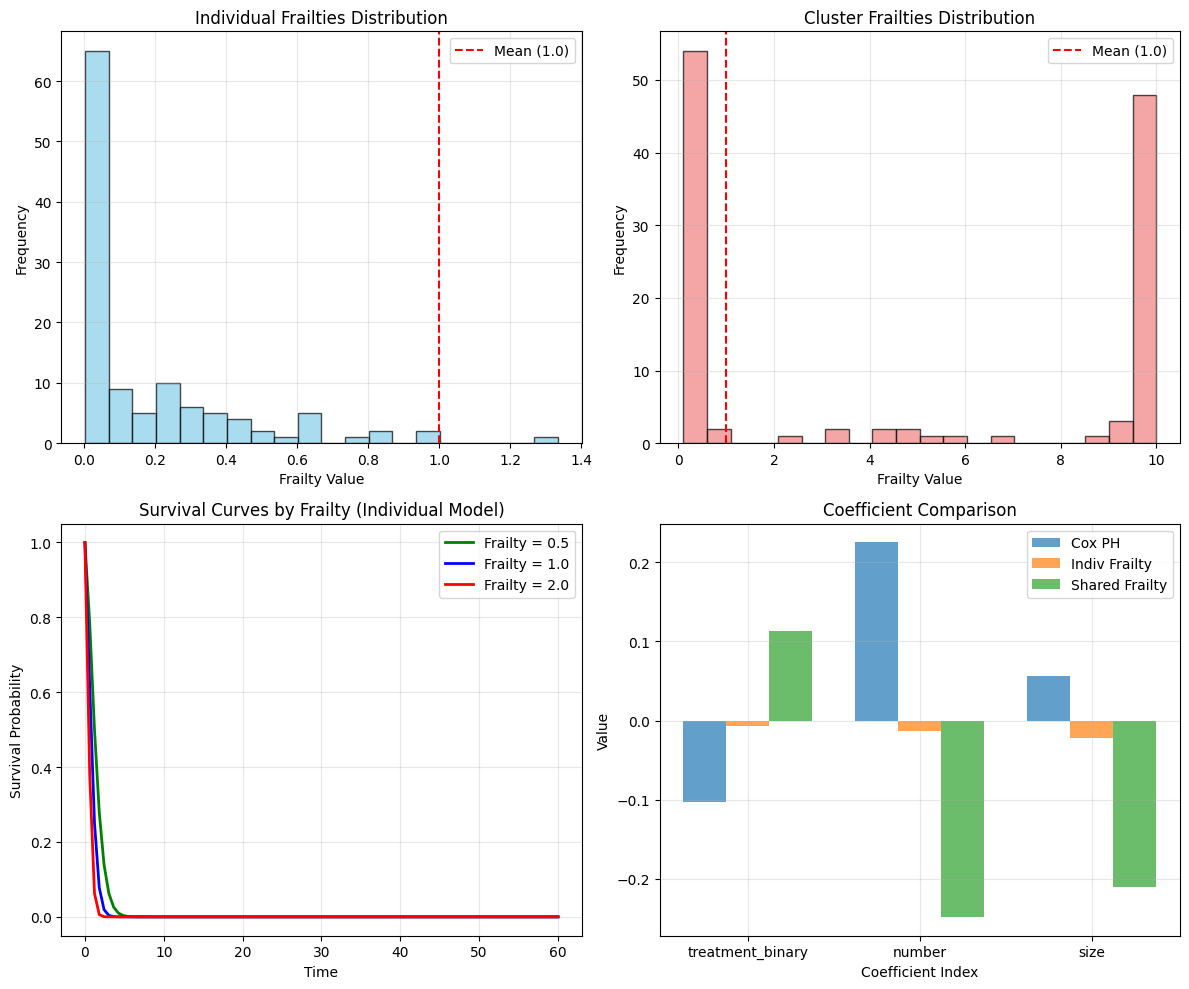

In [13]:
# ============================================================================
# Visualization
# ============================================================================

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Individual frailties distribution
axes[0, 0].hist(ifm.frailties, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(1.0, color='red', linestyle='--', label='Mean (1.0)')
axes[0, 0].set_xlabel('Frailty Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Individual Frailties Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cluster frailties distribution
axes[0, 1].hist(frailty_values, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(1.0, color='red', linestyle='--', label='Mean (1.0)')
axes[0, 1].set_xlabel('Frailty Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Cluster Frailties Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Survival curves for different frailty values
axes[1, 0].set_title('Survival Curves by Frailty (Individual Model)')
t_range = np.linspace(0, df_first['stop'].max(), 100)
X_example = np.array([[1, 0, 2, 3]])  # Example patient

# Plot for different frailty values
frailty_levels = [0.5, 1.0, 2.0]
colors = ['green', 'blue', 'red']

for frailty, color in zip(frailty_levels, colors):
    # Adjust survival for frailty
    eta = X_example @ ifm.beta
    S0 = ifm._baseline_survival(t_range, ifm.baseline_params)
    S_frailty = S0 ** (frailty * np.exp(eta[0]))
    axes[1, 0].plot(t_range, S_frailty, color=color, linewidth=2,
                    label=f'Frailty = {frailty}')

axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Survival Probability')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Coefficient comparison
axes[1, 1].set_title('Coefficient Comparison')
models = ['Cox PH', 'Indiv Frailty', 'Shared Frailty']
cox_coefs = cph.params_.values.tolist() # Corrected from cph.params
indiv_coefs = ifm.beta[1:].tolist()  # Skip intercept
shared_coefs = sfm.beta.tolist()

# Align coefficients
n_coefs = min(len(cox_coefs), len(indiv_coefs), len(shared_coefs))
x = np.arange(n_coefs)
width = 0.25

axes[1, 1].bar(x - width, cox_coefs[:n_coefs], width, label='Cox PH', alpha=0.7)
axes[1, 1].bar(x, indiv_coefs[:n_coefs], width, label='Indiv Frailty', alpha=0.7)
axes[1, 1].bar(x + width, shared_coefs[:n_coefs], width, label='Shared Frailty', alpha=0.7)

axes[1, 1].set_xlabel('Coefficient Index')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(X_cols[:n_coefs])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model Comparison and Interpretation

In [14]:
# ============================================================================
# Model Interpretation
# ============================================================================

print("\n" + "="*60)
print("MODEL INTERPRETATION")
print("="*60)

print("\n1. Individual Frailty Model:")
print("   - Accounts for unobserved heterogeneity between individuals")
print("   - Frailty variance (theta) indicates degree of heterogeneity")
print(f"   - Theta = {ifm.theta:.4f} suggests {'moderate' if ifm.theta > 0.1 else 'low'} heterogeneity")

print("\n2. Shared Frailty Model:")
print("   - Accounts for within-cluster correlation (multiple events per patient)")
print("   - Useful for recurrent event data")
print(f"   - Theta = {sfm.theta:.4f} suggests {'substantial' if sfm.theta > 0.1 else 'minimal'} cluster effect")

print("\n3. Comparison with Cox PH:")
print("   - Frailty models adjust for unobserved heterogeneity")
print("   - Coefficients may differ due to this adjustment")
print("   - Higher frailty variance suggests important unmeasured factors")

print("\n4. Practical Recommendations:")
print("   - For independent events: Use Cox PH or Individual Frailty")
print("   - For clustered/recurrent events: Use Shared Frailty")
print("   - Large frailty variance (> 0.5): Important unmeasured factors present")


MODEL INTERPRETATION

1. Individual Frailty Model:
   - Accounts for unobserved heterogeneity between individuals
   - Frailty variance (theta) indicates degree of heterogeneity
   - Theta = 0.5000 suggests moderate heterogeneity

2. Shared Frailty Model:
   - Accounts for within-cluster correlation (multiple events per patient)
   - Useful for recurrent event data
   - Theta = 10835.9275 suggests substantial cluster effect

3. Comparison with Cox PH:
   - Frailty models adjust for unobserved heterogeneity
   - Coefficients may differ due to this adjustment
   - Higher frailty variance suggests important unmeasured factors

4. Practical Recommendations:
   - For independent events: Use Cox PH or Individual Frailty
   - For clustered/recurrent events: Use Shared Frailty
   - Large frailty variance (> 0.5): Important unmeasured factors present


### Summary and Conclusion

Frailty models extend traditional survival analysis methods, such as the Cox proportional hazards model, by incorporating a random effect (frailty) to account for unobserved heterogeneity and clustering in time-to-event data. This heterogeneity arises from unmeasured factors that influence the hazard rate, leading to biased estimates if ignored. Key types include individual frailty models, which assign unique frailties to each subject or observation to capture personal-level variation (though less common and harder to identify in non-clustered data), and shared frailty models, which apply a common frailty within clusters (e.g., families) or across recurrent events for the same individual, inducing dependence and better handling correlated outcomes like repeated tumor recurrences.


In the R tutorial using the `bladder1` dataset from the `survival` package, we analyzed recurrent bladder cancer events in 85 patients. The dataset, in counting-process format, includes covariates like treatment (`treatment`), initial tumor number, and size. We fitted a standard Cox model (ignoring clustering), an individual frailty model  and a shared frailty model using two coustom functions.  Results showed significant frailty variance in the shared model, indicating unobserved patient-specific factors, with treatment reducing hazard and initial tumors increasing it

Frailty models are essential for robust survival analysis in the presence of unobserved heterogeneity or dependent events, preventing underestimation of variability and improving model fit, as seen in the bladder cancer example where shared frailty revealed clustering effects. They enable more accurate inference in fields like medicine, epidemiology, and reliability engineering, though assumptions about frailty distribution (e.g., gamma for constant dependence) must be carefully chosen and tested. In practice, shared frailty is particularly valuable for recurrent or clustered data, while individual frailty suits broader heterogeneity exploration. Overall, integrating frailty enhances interpretability, such as through selection effects where frailer individuals exit early, leaving robust survivors, and supports better decision-making in risk assessment.


## Resources


- **Book: Frailty Models in Survival Analysis** by Andreas Wienke (2010). This comprehensive text covers univariate and multivariate frailty models, with emphasis on real-data applications and statistical techniques.
  
- **Tutorial Paper: A Tutorial on Frailty Models** by Theodor A. Balan and Hein Putter (2020). An accessible guide illustrating frailty concepts, selection effects, and implementation for survival outcomes.

- **Book: Applied Survival Analysis Using R** by Dirk F. Moore (2016). Focuses on practical survival analysis in R, including frailty models, with code examples and integration of packages like `survival`.

- **R Package Documentation**:
  - `survival` package vignette on frailty models (available via `vignette("frailty", package="survival")` in R).
  - `frailtypack` package on CRAN: Provides advanced tools for frailty models, including penalized and joint models (https://cran.r-project.org/web/packages/frailtypack/index.html).
  - `coxme` package for mixed-effects Cox models with frailty (https://cran.r-project.org/web/packages/coxme/index.html).



